In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error

In [ ]:
stock_data = pd.read_excel("stock_data.xlsx")

stock_data

In [ ]:
plt.plot(stock_data["Date"], stock_data["SPY"])
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(stock_data["SPY"].to_numpy().reshape(-1, 1))

In [ ]:
data_scaled.shape

In [ ]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i: (i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 20
X, y = create_dataset(data_scaled, time_step)

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)
X.shape

In [ ]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test,y_test))

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
train_score = mean_squared_error(y_train[:,0], train_predict[:,0])
test_score = mean_squared_error(y_test[:,0], test_predict[:,0])

print(f"Train MSE: {train_score: .4f}")
print(f"Test MSE: {test_score: .4f}")

In [ ]:
plt.plot(scaler.inverse_transform(data_scaled), label="SPY (Original)")
train_plot = np.empty_like(data_scaled)
train_plot[:,:] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_plot, label="In-Sample Prediction")

test_plot = np.empty_like(data_scaled)
test_plot[:,:] = np.nan
test_plot[len(train_predict) + 1:len(train_predict) + len(test_predict) + 1, :] = test_predict
plt.plot(test_plot, label="Out-Sample Prediction")
plt.legend()
plt.show()

## Comparison with ARIMA

In [168]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(stock_data["SPY"].to_numpy().reshape(-1, 1))
y_train, y_test = y[:train_size], y[train_size:]

p, d, q = 1, 1, 0
arima_model = ARIMA(y_train, order = (p, d, q))
arima_fitted = arima_model.fit()

print(arima_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  776
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2026.964
Date:                Sat, 09 Nov 2024   AIC                          -4049.928
Time:                        11:54:21   BIC                          -4040.622
Sample:                             0   HQIC                         -4046.347
                                - 776                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1482      0.018     -8.213      0.000      -0.184      -0.113
sigma2         0.0003   8.11e-06     38.615      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.14   Jarque-

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [170]:
train_pred = arima_fitted.predict(start=0, end=len(y_train)-1)
test_pred = arima_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) -1)

In [172]:
train_predict = scaler.inverse_transform(train_pred.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [174]:
train_score = mean_squared_error(y_train[:,0], train_predict[:,0])
test_score = mean_squared_error(y_test[:,0], test_predict[:,0])

print(f"Train MSE: {train_score: .4f}")
print(f"Test MSE: {test_score: .4f}")

Train MSE:  21.8428
Test MSE:  812.6733


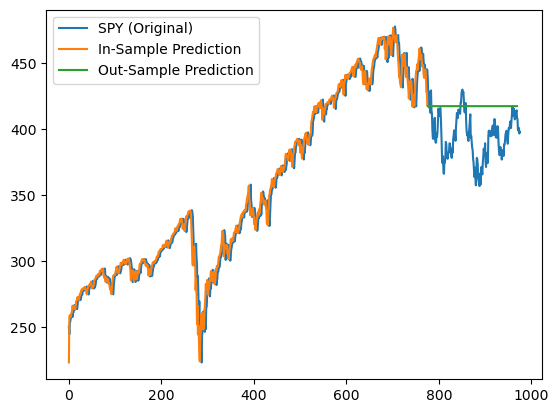

In [176]:
plt.plot(scaler.inverse_transform(data_scaled), label="SPY (Original)")
train_plot = np.empty_like(data_scaled)
train_plot[:,:] = np.nan
train_plot[:len(train_predict), :] = train_predict
plt.plot(train_plot, label="In-Sample Prediction")

test_plot = np.empty_like(data_scaled)
test_plot[:,:] = np.nan
test_plot[len(y_train):len(y_train) + len(y_test), :] = test_predict
plt.plot(test_plot, label="Out-Sample Prediction")
plt.legend()
plt.show()

## Comparison with ARIMA-GARCH

In [201]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(stock_data["SPY"].to_numpy().reshape(-1, 1))
y_train, y_test = y[:train_size], y[train_size:]

p, d, q = 1, 1, 0
arima_model = ARIMA(y_train, order = (p, d, q))
arima_fitted = arima_model.fit()
arima_residuals = arima_fitted.resid

garch_model = arch_model(arima_residuals, vol='Garch', p=1, q=1)
garch_fitted = garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1378145715.941821
Iteration:      2,   Func. Count:     19,   Neg. LLF: 33794.722106500456
Iteration:      3,   Func. Count:     30,   Neg. LLF: 54485596.575305834
Iteration:      4,   Func. Count:     42,   Neg. LLF: 1244.5306530459357
Iteration:      5,   Func. Count:     53,   Neg. LLF: 153402.51799665304
Iteration:      6,   Func. Count:     65,   Neg. LLF: 155530322.41423202
Iteration:      7,   Func. Count:     78,   Neg. LLF: 40294084.13213287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2189.8374312833193
            Iterations: 11
            Function evaluations: 87
            Gradient evaluations: 7


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003359. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [203]:
garch_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2189.84
Distribution:                  Normal   AIC:                          -4371.67
Method:            Maximum Likelihood   BIC:                          -4353.06
                                        No. Observations:                  776
Date:                Sat, Nov 09 2024   Df Residuals:                      775
Time:                        12:12:47   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6948e-03  2.450e-06    691.731      0.000 [1.690e-03,1.700e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.7314e-06  1.555e-10  4.329e+04      0.000 [6.731e-06,6.732e-06]
alpha[1]       0.2000  4.861e-02      4.114  3.882e-05     [  0.105,  0.295]
beta[1]        0.7800  4.055e-02     19.235  1.872e-82     [  0.701,  0.859]
============================================================================

Covariance estimator: robust
"""

In [205]:
garch_residuals = garch_fitted.std_resid

from statsmodels.stats.diagnostic import het_arch
arch_test_stat, arch_test_pval, _, _ = het_arch(garch_residuals**2)

print(f"ARCH Test p-value: {arch_test_pval}")

ARCH Test p-value: 0.9994164793046664


In [209]:
arima_test_pred.shape

(200,)

In [211]:
arima_train_pred = arima_fitted.predict(start=0, end=len(y_train)-1)
garch_train_predictions = np.sqrt(garch_fitted.forecast(horizon=len(y_train)).variance.values[-1, :])
train_pred = arima_train_pred + garch_train_predictions

arima_test_pred = arima_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) -1)
garch_test_predictions = np.sqrt(garch_fitted.forecast(horizon=len(y_test)).variance.values[-1, :])
test_pred = arima_test_pred + garch_test_predictions

In [215]:
train_predict = scaler.inverse_transform(train_pred.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [217]:
train_score = mean_squared_error(y_train[:,0], train_predict[:,0])
test_score = mean_squared_error(y_test[:,0], test_predict[:,0])

print(f"Train MSE: {train_score: .4f}")
print(f"Test MSE: {test_score: .4f}")

Train MSE:  42.5421
Test MSE:  1089.1817


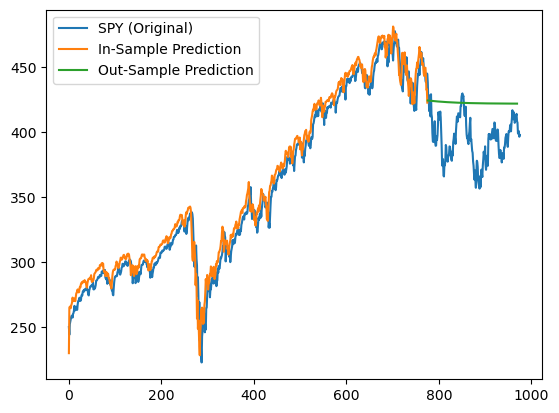

In [221]:
plt.plot(scaler.inverse_transform(data_scaled), label="SPY (Original)")
train_plot = np.empty_like(data_scaled)
train_plot[:,:] = np.nan
train_plot[:len(train_predict), :] = train_predict
plt.plot(train_plot, label="In-Sample Prediction")

test_plot = np.empty_like(data_scaled)
test_plot[:,:] = np.nan
test_plot[len(y_train):len(y_train) + len(y_test), :] = test_predict
plt.plot(test_plot, label="Out-Sample Prediction")
plt.legend()
plt.show()